<a href="https://colab.research.google.com/github/Anmwai/Fraud-Prevention/blob/main/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Fraud Detection With Neo4j & Graph Data Science
This analysis uses Neo4j and Graph Data Science (GDS) to explore an anonymized data sample from a Paysim dataset. The notebook is split up into the following sections to cover various stages of the graph data science workflow:

Notebook Setup
* Part 1: First Party Fraud;

> Identify clusters of clients sharing PII

> Compute pairwise similarity based on shared PII

> Compute first-party fraud score

> Label some clients as first-party fraudsters

* Part 2: Second-party Fraud;

> Identify and explore transactions (money transfers) between first-party fraudsters and other clients

> Detect second-party fraud networks

* Part 3: Predicting Fraud Risk Accounts with Machine Learning; Neural Networks;

> Integrating Neo4j with Pytorch Geometric for fraud prediction

> Create graph embeddings to capture node similarity based on clients and transactios

> Train the GNN model in PyG

> Create predictions and optionally store them in neo4j


## Notebook Setup

In [47]:
!pip install -U graphdatascience

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
!pip install sentence_transformers neo4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
from neo4j import GraphDatabase
import pandas as pd
import configparser
import os
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 50)

In [51]:
import torch
import pandas as pd
import numpy as np
from torch.nn import Linear
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer

import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, to_hetero

from torch_geometric.data import HeteroData
from torch_geometric.transforms import ToUndirected, RandomLinkSplit

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Dataset Introduction

We will  be using an anonymized sample of customer accounts and transactions from a real-world Paysim dataset. Prior to ingesting the data into graph, the original identification numbers were removed and categorical values were masked. Paysim is a synthetic dataset that mimics real world mobile money transfer network.

Below is a visualization of the graph schema:
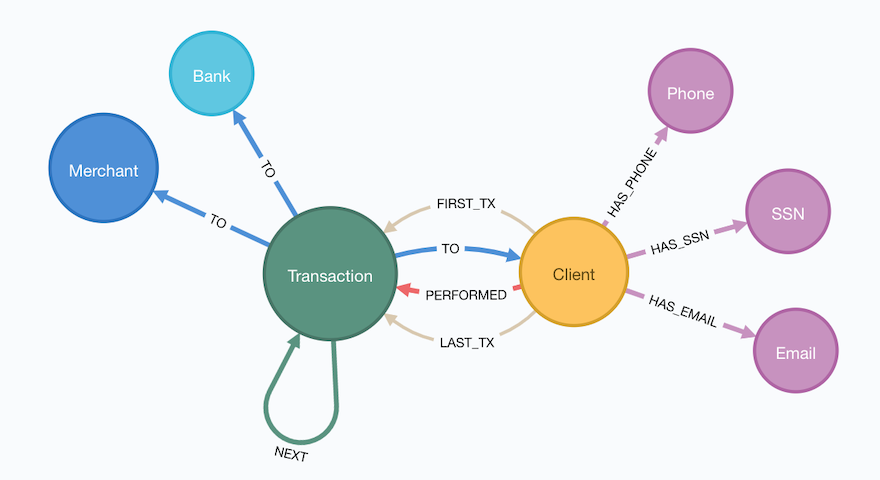

In [52]:
driver = GraphDatabase.driver('bolt://34.205.9.24:7687', auth=('neo4j', 'lining-pointers-readiness'))
driver.verify_connectivity()

In [53]:
# Helper functions

def run(driver, query, params={}):
    with driver.session() as session:
        if params:
            return [r for r in session.run(query, params)]
        return [r for r in session.run(query)]
    
def clear_graph(driver, graph_name):
    if run(driver, f"CALL gds.graph.exists('{graph_name}') YIELD exists RETURN exists")[0].get("exists"):
        run(driver, f"CALL gds.graph.drop('{graph_name}')")

def clear_all_graphs(driver):
    graphs = run(driver, 'CALL gds.graph.list() YIELD graphName RETURN collect(graphName) as graphs')[0].get('graphs')
    for g in graphs:
        run(driver, f"CALL gds.graph.drop('{g}')")

def identifier_degrees(user_label, degree_property):
    params = {'userLabel': user_label, 'property': degree_property}
    clear_graph(driver, 'id-projection')
    print(f'projecting identity graph for {user_label}')
    run(driver, '''
        CALL gds.graph.project('id-projection',
            [$userLabel, 'Card', 'Device', 'IP'],
            {
                HAS_CC: {orientation: 'REVERSE'},
                HAS_IP: {orientation: 'REVERSE'},
                USED: {orientation: 'REVERSE'}
            }
        )
    ''', params=params)

    print(f'calculating degree centrality')
    run(driver, '''
        CALL gds.degree.mutate('id-projection', {
            mutateProperty: $property
        })
    ''', params=params)

    print(f'writing degree scores to {degree_property}')
    run(driver, '''
        CALL gds.graph.writeNodeProperties('id-projection',
            [$property],
            ['Card', 'Device', 'IP']
        )
    ''', params=params)
    
    print(f'updating indexes...')
    run(driver, f'''
        CREATE INDEX card_{degree_property} IF NOT EXISTS FOR (c:Card) on c.{degree_property};
    ''')
    run(driver, f'''
        CREATE INDEX device_{degree_property} IF NOT EXISTS FOR (c:Device) on c.{degree_property};
    ''')
    run(driver, f'''
        CREATE INDEX ip_{degree_property} IF NOT EXISTS FOR (c:IP) on c.{degree_property};
    ''')
    clear_graph(driver, 'id-projection')
    print('finished.')

# Data Exploration

We'll breakdown the high-level counts by labels and relationships in our dataset.

In [19]:
# total node counts
result = run(driver, 'CALL apoc.meta.stats() YIELD labels AS nodeCounts')
pd.DataFrame(dict(result[0])).transpose()

,Bank,CashIn,CashOut,Client,Debit,Email,FirstPartyFraudster,Merchant,Mule,Payment,Phone,SSN,SecondPartyFraud,SecondPartyFraudSuspect,Transaction,Transfer
nodeCounts,3,149037,76023,2432,4392,2229,17,347,433,74577,2234,2238,46,46,323489,19460


In [20]:
# total relationship counts
result = run(driver, 'CALL apoc.meta.stats() YIELD relTypesCount as relationshipCounts')
pd.DataFrame(dict(result[0])).transpose()

,FIRST_TX,HAS_EMAIL,HAS_PHONE,HAS_SSN,LAST_TX,NEXT,PERFORMED,SHARED_IDENTIFIERS,SIMILAR_TO,TO,TRANSFER_TO
relationshipCounts,2331,2432,2432,2432,2331,321157,323186,759,4554,323475,110


In [21]:
# Checking the types of transactions & their ratio

result = run(driver, '''
    MATCH (t:Transaction)
    WITH count(t) AS globalCnt
    UNWIND ['CashIn', 'CashOut', 'Payment', 'Debit', 'Transfer'] AS txType
    CALL apoc.cypher.run('MATCH (t:' + txType + ')
    RETURN count(t) AS txCnt', {})
  YIELD value
  RETURN txType, value.txCnt AS NumberOfTransactions,
  round(toFloat(value.txCnt)/toFloat(globalCnt), 2) AS `%Transactions`
ORDER BY `%Transactions` DESC''')
pd.DataFrame(dict(record) for record in result)

,txType,NumberOfTransactions,%Transactions
0,CashIn,149037,0.46
1,CashOut,76023,0.24
2,Payment,74577,0.23
3,Transfer,19460,0.06
4,Debit,4392,0.01


##1: First-party Fraud

First party fraud can be identified by performing entity link analysis to detect identities linked to other identities via shared Personally Identifiable Information (PII). In our dataset, this information is SSN, Email and Phone Number.

We will run on the hypothesis that clients who share PIIs are suspicious and have a higher ppotential to commit fraud. However, not all shared identifiers are linked to suspicious activity. Hence, therefore, we will compute a fraud score based on the shared PII relationships and the clients with the top percentile are labelled as fraudsters.

In [61]:
# Setting a label for flagged users will enable faster lookups in cypher and faster gds projections
run(driver, 'MATCH(u:User) WHERE u.fraudMoneyTransfer=1 SET u:FlaggedUser RETURN count(u)')

[<Record count(u)=0>]

### 1.1 Identifying clusters of clients sharing PII

In [62]:
# Identifying clients that share identifiers
# Matching clients who share PIIs
result = run(driver,'''
    MATCH (c1:Client)-[:HAS_EMAIL|:HAS_PHONE|:HAS_SSN]->(n) <-[:HAS_EMAIL|:HAS_PHONE|:HAS_SSN]-(c2:Client)
    WHERE id(c1) < id(c2)
    RETURN c1.id, c2.id, count(*) AS freq
    ORDER BY freq DESC''')
pd.DataFrame(dict(record) for record in result)

,c1.id,c2.id,freq
0,4952527271473904,4816336012071985,3
1,4883445100935916,4708373581412325,3
2,4658150168863397,4100374538108184,3
3,4673951123644611,4795773320377768,3
4,4192214340630620,4912097363222923,3
...,...,...,...
754,4910140986334626,4114683318919154,1
755,4454780847105236,4210575070378533,1
756,4721862020593706,4210575070378533,1
757,4445521165797820,4210575070378533,1


In [63]:
# THerefore, the number of clients sharing PII are:
result = run(driver,'''
    MATCH (c1:Client)-[:HAS_EMAIL|:HAS_PHONE|:HAS_SSN]->(n) <-[:HAS_EMAIL|:HAS_PHONE|:HAS_SSN]-(c2:Client)
    WHERE id(c1) <> id(c2)
    RETURN count(DISTINCT c1.id) AS freq''')
print('Number of clients that share identifiers are:')
pd.DataFrame(dict(record) for record in result)

Number of clients that share identifiers are:


,freq
0,336


In [64]:
# Let's now create a new relationship that connects the clients that share PII and add the number of shared identifiers as a property on that relationship
result = run(driver,'''
    MATCH (c1:Client)-[:HAS_EMAIL|:HAS_PHONE|:HAS_SSN] ->(n)<- [:HAS_EMAIL|:HAS_PHONE|:HAS_SSN]-(c2:Client)
    WHERE id(c1) < id(c2)
    WITH c1, c2, count(*) as cnt
    MERGE (c1) - [:SHARED_IDENTIFIERS {count: cnt}] -> (c2)''')
pd.DataFrame(dict(record) for record in result)

""


In [65]:
result = run(driver,'''
    MATCH p = (:Client) - [s:SHARED_IDENTIFIERS] -> (:Client) WHERE s.count >= 2 RETURN p limit 25''')
pd.DataFrame(dict(record) for record in result)

,p
0,((count))
1,((count))
2,((count))
3,((count))
4,((count))
5,((count))
6,((count))
7,((count))
8,((count))
9,((count))


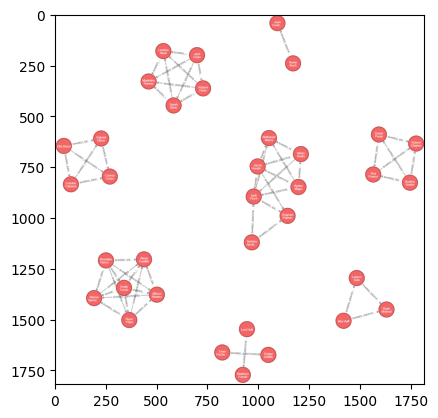

In [66]:
# Visualizing the graph
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_path = "graph.png"
image = mpimg.imread(image_path)
plt.imshow(image)
plt.show()

This graph shows the unique clusters of clients who share the same identifiers as visualised in neo4j. It displays 35 nodes & 57 relatioships.

### 1.2 Computing pairwise similarity based on shared PII

Identities that are connected to highly reused identifiers are hypothesized to have higher potential for fraud.

We will construct a workflow with graph algorithms to detect fraud rings, score clients based on the number of common connections and rank them to select the top few suspicious clients and label them as fraudsters.

This involes identifying clusters of clients sharing PII using a community detection algorithm( Weakly Conected Components) and comparing it with clusters usinf=g pairwise similarity algorithms(Node similarity), then calculating the Degree Centrality by calculating and assigning fraud scores, and then labelling fraudulent clients, based on the result.


In [68]:
result = run(driver,'''
    CALL gds.graph.project('wcc',
      {
        Client: {
            label: 'Client'
        }
    },
    {
        SHARED_IDENTIFIERS:{
            type: 'SHARED_IDENTIFIERS',
            orientation: 'UNDIRECTED',
            properties: {
                count: {
                    property: 'count'
                }
            }
        }
    }
) YIELD graphName,nodeCount,relationshipCount,projectMillis''')
pd.DataFrame(dict(record) for record in result)

ClientError: ignored

In [69]:
# Running weakly connected components to find clusters sharing PII
result = run(driver,'''
CALL gds.wcc.stream('wcc',
    {
        nodeLabels: ['Client'],
        relationshipTypes: ['SHARED_IDENTIFIERS'],
        consecutiveIds: true
    }
)
YIELD nodeId, componentId
RETURN gds.util.asNode(nodeId).id AS clientId, componentId
ORDER BY componentId LIMIT 20''')

pd.DataFrame(dict(record) for record in result)

,clientId,componentId
0,4997933060327094,0
1,4776276949898423,1
2,4858607188760216,2
3,4287186486553145,3
4,4661202154682409,4
5,4649268238636650,5
6,4426707672690219,6
7,4922246870240518,7
8,4415848797892554,8
9,4548497513788330,9


In [70]:
# Writing the results using cypher to filter clusters based on the size (>1) and setting a property on the client nodes
result = run(driver,'''
CALL gds.wcc.stream('wcc',
    {
        nodeLabels: ['Client'],
        relationshipTypes: ['SHARED_IDENTIFIERS'],
        consecutiveIds: true
    }
)
YIELD componentId, nodeId
WITH componentId AS cluster, gds.util.asNode(nodeId) AS client
WITH cluster, collect(client.id) AS clients
WITH cluster, clients, size(clients) AS clusterSize WHERE clusterSize > 1
UNWIND clients AS client
MATCH (c:Client) WHERE c.id = client
SET c.firstPartyFraudGroup=cluster''')
pd.DataFrame(dict(record) for record in result)


""


In [71]:
result = run(driver,'''
    MATCH (c:Client)
    WITH c.firstPartyFraudGroup AS fpGroupID, collect(c.id) AS fGroup
    WITH  *, size(fGroup) AS groupSize WHERE groupSize >= 9
    WITH collect(fpGroupID) AS fraudRings
    MATCH p=(c:Client)-[:HAS_SSN|HAS_EMAIL|HAS_PHONE]->()
    WHERE c.firstPartyFraudGroup IN fraudRings
    RETURN p''')
print("These are the clusters with more than 9 client nodes:")
pd.DataFrame(dict(record) for record in result)

These are the clusters with more than 9 client nodes:


,p
0,(())
1,(())
2,(())
3,(())
4,(())
...,...
292,(())
293,(())
294,(())
295,(())


#### Visualizing the results in neo4j


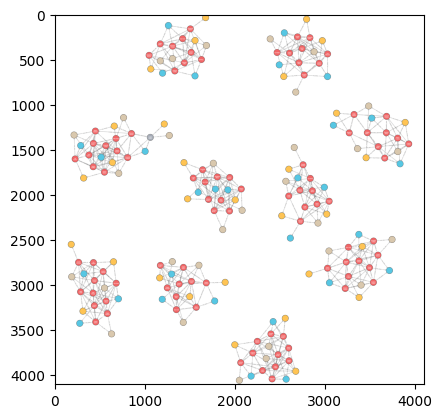

In [72]:
image_path = "graph (2).png"
image = mpimg.imread(image_path)
plt.imshow(image)
plt.show()

In [73]:
# Let's now compute the pairwise similarity scores using jaccard metric 
# Node similarity algorithms work on bipartite graphs. we project client nodes (one type) and three identifiers nodes (that are considered as second type) into memory.
result = run(driver,'''
MATCH(c:Client) WHERE c.firstPartyFraudGroup is not NULL
WITH collect(c) as clients
MATCH(n) WHERE n:Email OR n:Phone OR n:SSN
WITH clients, collect(n) as identifiers
WITH clients + identifiers as nodes

MATCH(c:Client) -[:HAS_EMAIL|:HAS_PHONE|:HAS_SSN]->(id)
WHERE c.firstPartyFraudGroup is not NULL
WITH nodes, collect({source: c, target: id}) as relationships

CALL gds.graph.project.cypher('similarity',
    "UNWIND $nodes as n RETURN id(n) AS id,labels(n) AS labels",
    "UNWIND $relationships as r RETURN id(r['source']) AS source, id(r['target']) AS target, 'HAS_IDENTIFIER' as type",
    { parameters: {nodes: nodes, relationships: relationships}}
)
YIELD graphName, nodeCount, relationshipCount, projectMillis
RETURN graphName, nodeCount, relationshipCount, projectMillis''')
pd.DataFrame(dict(record) for record in result)

,graphName,nodeCount,relationshipCount,projectMillis
0,similarity,7037,1008,136


In [74]:
# mutating the in-memory graph -> the aim is to optimize the algorithm execution times
result = run(driver,'''
CALL gds.nodeSimilarity.mutate('similarity',
    {
        topK:15,
        mutateProperty: 'jaccardScore',
        mutateRelationshipType:'SIMILAR_TO'
    }
)''')
pd.DataFrame(dict(record) for record in result)

,preProcessingMillis,computeMillis,mutateMillis,postProcessingMillis,nodesCompared,relationshipsWritten,similarityDistribution,configuration
0,0,32,15,-1,336,1518,"{'p1': 0.19999980926513672, 'max': 1.0000066757202148, 'p5': 0.19999980926513672, 'p90': 0.5000028610229492, 'p50': 0.19999980926513672, 'p95': 1.0000066757202148, 'p10': 0.19999980926513672, 'p75': 0.5000028610229492, 'p99': 1.0000066757202148, 'p25': 0.19999980926513672, 'p100': 1.0000066757202148, 'min': 0.19999980926513672, 'mean': 0.3347832789062983, 'stdDev': 0.20693545125522303}","{'topK': 15, 'similarityMetric': 'JACCARD', 'bottomK': 10, 'bottomN': 0, 'mutateRelationshipType': 'SIMILAR_TO', 'topN': 0, 'concurrency': 4, 'jobId': '5a0bb1e9-7d22-4fc3-a708-d832f72277eb', 'degreeCutoff': 1, 'similarityCutoff': 1e-42, 'logProgress': True, 'nodeLabels': ['*'], 'sudo': False, 'relationshipTypes': ['*'], 'mutateProperty': 'jaccardScore'}"


In [75]:
# Writing the results to the database
result = run(driver,'''
CALL gds.graph.writeRelationship('similarity', 'SIMILAR_TO', 'jaccardScore')''')
pd.DataFrame(dict(record) for record in result)

,writeMillis,graphName,relationshipType,relationshipProperty,relationshipsWritten,propertiesWritten
0,102,similarity,SIMILAR_TO,jaccardScore,1518,1518


### 1.3 Computing  First-party Fraud Score

The Weighted Degree Centrality algorithm calculates the firstPartyFraudScore for a given node in a cluster by aggregating the similarity scores (jaccardScore) of the incoming SIMILAR_TO relationships. This score indicates the level of similarity between the node and other nodes in the cluster in terms of shared identifiers. A higher firstPartyFraudScore suggests that the node has a greater potential for committing fraud.

In [76]:
result = run(driver,'''
CALL gds.degree.write('similarity',
    {
        nodeLabels: ['Client'],
        relationshipTypes: ['SIMILAR_TO'],
        relationshipWeightProperty: 'jaccardScore',
        writeProperty: 'firstPartyFraudScore'
    }
)'''
)
pd.DataFrame(dict(record) for record in result)

,nodePropertiesWritten,centralityDistribution,writeMillis,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,336,"{'p99': 3.1000051498413086, 'min': 0.19999980926513672, 'max': 3.500014305114746, 'mean': 1.5125004393713815, 'p90': 2.500014305114746, 'p50': 1.4000005722045898, 'p999': 3.500014305114746, 'p95': 2.800002098083496, 'p75': 2.000014305114746}",7,22,0,1,"{'jobId': 'a33f24e3-7399-4832-aaf3-641456d2b10f', 'orientation': 'NATURAL', 'writeConcurrency': 4, 'writeProperty': 'firstPartyFraudScore', 'logProgress': True, 'relationshipWeightProperty': 'jaccardScore', 'nodeLabels': ['Client'], 'sudo': False, 'relationshipTypes': ['SIMILAR_TO'], 'concurrency': 4}"


#### Attaching fraudster labels
Clients are identified as potential fraudsters based on their first-party fraud score which is computed using a weighted degree centrality algorithm. A threshold value (X) is set, and clients with a first-party fraud score greater than this threshold are labeled as top X percentile fraudsters. For instance, if the 95th percentile is used as the threshold, the top 5% of clients with the highest first-party fraud score are identified and a property FirstPartyFraudster is set on their corresponding Client node.


In [77]:
result = run(driver,'''
MATCH(c:Client)
WHERE c.firstPartyFraudScore IS NOT NULL
WITH percentileCont(c.firstPartyFraudScore, 0.95) AS firstPartyFraudThreshold

MATCH(c:Client)
WHERE c.firstPartyFraudScore > firstPartyFraudThreshold
SET c:FirstPartyFraudster''')
pd.DataFrame(dict(record) for record in result)

""


## Part 2: Second-party Fraud

We hypothesize that clients who engage in transactions with first-party fraudsters may be considered potential suspects for second-party fraud.

We'll start with identifying clients who transact with first party fraudsters but aren't identified as fraudsters

In [78]:
result = run(driver,'''
MATCH p=(:Client:FirstPartyFraudster)-[]-(:Transaction)-[]-(c:Client)
WHERE NOT c:FirstPartyFraudster
RETURN p''')
pd.DataFrame(dict(record) for record in result)

,p
0,"((), ())"
1,"((), ())"
2,"((), ())"
3,"((), ())"
4,"((), ())"
...,...
84,"((), ())"
85,"((), ())"
86,"((), ())"
87,"((), ())"


In [79]:
result = run(driver,'''
MATCH (:Client:FirstPartyFraudster)-[]-(txn:Transaction)-[]-(c:Client)
WHERE NOT c:FirstPartyFraudster
UNWIND labels(txn) AS transactionType
RETURN transactionType, count(*) AS freq''')
print('These are the types of transactions that these clients perform with first party fraudsters:')
pd.DataFrame(dict(record) for record in result)

These are the types of transactions that these clients perform with first party fraudsters:


,transactionType,freq
0,Transfer,89
1,Transaction,89


We will now proceed to establish TRANSFER_TO relationships between clients having firstPartyFraudster tags and other clients, while also incorporating the total amount from all such transactions as a property on the TRANSFER_TO relationships.


In [80]:
result = run(driver,'''
MATCH (c1:FirstPartyFraudster)-[]->(t:Transaction)-[]->(c2:Client)
WHERE NOT c2:FirstPartyFraudster
WITH c1, c2, sum(t.amount) AS totalAmount
SET c2:SecondPartyFraudSuspect
CREATE (c1)-[:TRANSFER_TO {amount:totalAmount}]->(c2)''')
pd.DataFrame(dict(record) for record in result)


""


In [81]:
result = run(driver,'''
MATCH (c1:FirstPartyFraudster)<-[]-(t:Transaction)<-[]-(c2:Client)
WHERE NOT c2:FirstPartyFraudster
WITH c1, c2, sum(t.amount) AS totalAmount
SET c2:SecondPartyFraudSuspect
CREATE (c1)<-[:TRANSFER_TO {amount:totalAmount}]-(c2)''')
pd.DataFrame(dict(record) for record in result)

""


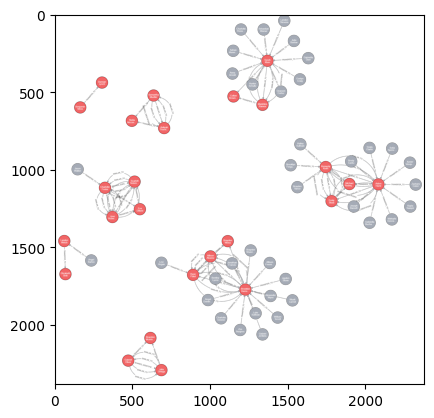

In [82]:
# Visualizing the results
image_path = "graph (3).png"
image = mpimg.imread(image_path)
plt.imshow(image)
plt.show()


Our goal is to identify clients who might have aided first party fraudsters and were not previously recognized as potential fraudsters. Our hypothesis suggests that clients who participate in Transfer transactions involving first party fraudsters, either as senders or recipients, may be involved in second party fraud.

To pinpoint these clients, we can use TRANSFER_TO relationships and apply the following approach:

> Utilize WCC (community detection) to identify groups of clients linked to first party fraudsters.

> Use PageRank (centrality) to score clients based on their impact in terms of the amount of money transferred to/from fraudsters.

> Assign a risk score (secondPartyFraudScore) to these clients.

We'll create an in-memory graph with client nodes & TRANSFER_TO relationships

In [83]:
result = run(driver,'''
CALL gds.graph.project('SecondPartyFraudNetwork',
    'Client',
    'TRANSFER_TO',
    {relationshipProperties:'amount'}
)''')
pd.DataFrame(dict(record) for record in result)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Client': {'label': 'Client', 'properties': {}}}","{'TRANSFER_TO': {'orientation': 'NATURAL', 'indexInverse': False, 'aggregation': 'DEFAULT', 'type': 'TRANSFER_TO', 'properties': {'amount': {'defaultValue': None, 'property': 'amount', 'aggregation': 'DEFAULT'}}}}",SecondPartyFraudNetwork,2432,110,70


In [84]:
# Calculating second-party fraud score
result = run(driver,'''
CALL gds.wcc.stream('SecondPartyFraudNetwork')
YIELD nodeId, componentId
WITH gds.util.asNode(nodeId) AS client, componentId AS clusterId
WITH clusterId, collect(client.id) AS cluster
WITH clusterId, size(cluster) AS clusterSize, cluster
WHERE clusterSize > 1
UNWIND cluster AS client
MATCH(c:Client {id:client})
SET c.secondPartyFraudGroup=clusterId''')
pd.DataFrame(dict(record) for record in result)

""


In [85]:
result = run(driver,'''
CALL gds.pageRank.stream('SecondPartyFraudNetwork',
    {relationshipWeightProperty:'amount'}
)YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS client, score AS pageRankScore

WHERE client.secondPartyFraudGroup IS NOT NULL
        AND pageRankScore > 0 AND NOT client:FirstPartyFraudster

MATCH(c:Client {id:client.id})
SET c:SecondPartyFraud
SET c.secondPartyFraudScore = pageRankScore''')
pd.DataFrame(dict(record) for record in result)

""


In [86]:
# Visualizing second party fraud networks
result = run(driver,'''
MATCH p=(:Client:FirstPartyFraudster)-[:TRANSFER_TO]-(c:Client)
WHERE NOT c:FirstPartyFraudster
RETURN p''')
pd.DataFrame(dict(record) for record in result)

,p
0,((amount))
1,((amount))
2,((amount))
3,((amount))
4,((amount))
...,...
105,((amount))
106,((amount))
107,((amount))
108,((amount))


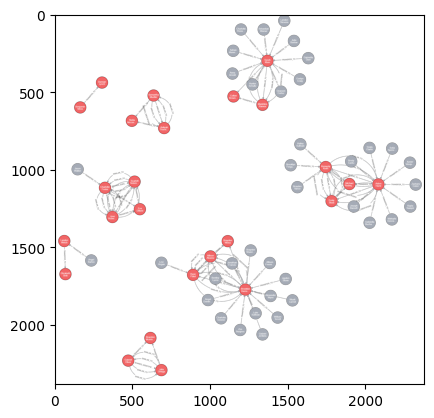

In [87]:
# Visualizing in neo4j, 2nd party fraudsters
image_path = "graph (5).png"
image = mpimg.imread(image_path)
plt.imshow(image)
plt.show()


In [63]:
# Removing the graph catalogue & writing the results back to the database
result = run(driver,'''
CALL gds.graph.list()
YIELD graphName AS namedGraph
WITH namedGraph
CALL gds.graph.drop(namedGraph)
YIELD graphName
RETURN graphName''')
pd.DataFrame(dict(record) for record in result)

,graphName
0,trans


## part 3: Training a GNN 


In [55]:
# Creating another in-memory graph that features clients & their transactions

fetch_data("""
CALL gds.graph.project('trans', ['Client', 'Mule', 'Debit', 'CashIn', 'CashOut', 'Transfer', 'Transaction'], 
  {PERFORMED: {orientation:'UNDIRECTED'}})
""")

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Debit': {'label': 'Debit', 'properties': {}}, 'Transaction': {'label': 'Transaction', 'properties': {}}, 'Mule': {'label': 'Mule', 'properties': {}}, 'CashOut': {'label': 'CashOut', 'properties': {}}, 'Transfer': {'label': 'Transfer', 'properties': {}}, 'CashIn': {'label': 'CashIn', 'properties': {}}, 'Client': {'label': 'Client', 'properties': {}}}","{'PERFORMED': {'orientation': 'UNDIRECTED', 'indexInverse': False, 'aggregation': 'DEFAULT', 'type': 'PERFORMED', 'properties': {}}}",trans,325921,646372,310


We'll use the FastRP algorithm to create embeddings that we'llfeed to the NN.  The FastRP algorithm will only consider the bipartite network ofclients & transactions and ignore client information. This way, we make sure to capture the transaction similarity based on only the transactions that appeared in the graph. First, we need to project the GDS in-memory graph.

In [ ]:
result = run(driver,
"""
CALL gds.fastRP.write('trans, {writeProperty:'fastrp', embeddingDimension:56})
""")
pd.DataFrame(dict(record) for record in result)

In [67]:
def fetch_data(query, params={}):
  with driver.session() as session:
    result = session.run(query, params)
    return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [ ]:
fetch_data("""
CALL gds.beta.node2vec.stream('trans', {embeddingDimension: 56})
YIELD nodeId, embedding
RETURN nodeId, embedding
""")

Let's fetch the data from Neo4j and create node mapping & features while retrieving data from neo4j.

In [31]:
def load_node(cypher, index_col, encoders=None, **kwargs):
    # Execute the cypher query and retrieve data from Neo4j
    df = fetch_data(cypher)
    df.set_index(index_col, inplace=True)
    # Define node mapping
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    # Define node features
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

In [32]:
# Creating edge index & features 
def load_edge(cypher, src_index_col, src_mapping, dst_index_col, dst_mapping,
                  encoders=None, **kwargs):
    # Execute the cypher query and retrieve data from Neo4j
    df = fetch_data(cypher)
    # Define edge index
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])
    # Define edge features
    edge_attr = None
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [33]:
# DEfining feature encoders
class SequenceEncoder(object):
    # The 'SequenceEncoder' encodes raw column strings into embeddings.
    def __init__(self, model_name='trans', device=None):
        self.device = device
        self.model = SentenceTransformer(model_name, device=device)

    @torch.no_grad()
    def __call__(self, df):
        x = self.model.encode(df.values, show_progress_bar=True,
                              convert_to_tensor=True, device=self.device)
        return x.cpu()

In [35]:
class TransactionEncoder(object):
    # The 'TransactionEncoder' splits the raw column strings by 'sep' and converts
    # individual elements to categorical labels.
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        genres = set(g for col in df.values for g in col.split(self.sep))
        mapping = {genre: i for i, genre in enumerate(genres)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for genre in col.split(self.sep):
                x[i, mapping[genre]] = 1
        return x

In [36]:
class IdentityEncoder(object):
    # The 'IdentityEncoder' takes the raw column values and converts them to
    # PyTorch tensors.
    def __init__(self, dtype=None, is_list=False):
        self.dtype = dtype
        self.is_list = is_list

    def __call__(self, df):
        if self.is_list:
            return torch.stack([torch.tensor(el) for el in df.values])
        return torch.from_numpy(df.values).to(self.dtype)

In [37]:
# construct client mappings and features that will be used as input to the pyG heterogeneous graph
client_query = """
MATCH (c:Client) RETURN c.ClientId AS clientId
"""

client_x, client_mapping = load_node(client_query, index_col='clientId')

In [ ]:
# Next, we will construct the transactions' mapping and features.
transaction_query = """
MATCH (t:Transaction-[:PERFORMED]->(mule:Mule)
WITH m, collect(mule.name) AS mule_list
RETURN t.trAansctionID AS transId, t.title AS title, apoc.text.join(mule_list, '|') AS mules, t.fastrp AS fastrp
"""

trans_x, trans_mapping = load_node(
    transaction_query, 
    index_col='transId', encoders={
        'title': SequenceEncoder(),
        'mule': GenresEncoder(),
        'fastrp': IdentityEncoder(is_list=True)
    })

In [ ]:
#  building a heterogeneous pyG graph

data = HeteroData()
# Add user node features for message passing:
data['client'].x = torch.eye(len(client_mapping), device=device)
# Add trasaction node features
data['transaction'].x = trans_x
# Add fraud ratings between users and movies
data['client', 'rates', 'trans'].edge_index = edge_index
data['client', 'rates', 'trans'].edge_label = edge_label
data.to(device, non_blocking=True)



In [ ]:
#  perform the train/test data split
data = ToUndirected()(data)
del data['trans', 'rev_rates', 'client'].edge_label  # Remove "reverse" label.

# 2. Perform a link-level split into training, validation, and test edges.
transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('client', 'rates', 'trans')],
    rev_edge_types=[('trans', 'rev_rates', 'client')],
)
train_data, val_data, test_data = transform(data)

In [72]:
# Defining the GNN
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [ ]:
weight = torch.bincount(train_data['client', 'trans'].edge_label)
weight = weight.max() / weight

def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

In [74]:
model = Model(hidden_channels=64).to(device)

AssertionError: ignored

In [ ]:
# Due to lazy initialization, we need to run one model step so the number
# of parameters can be inferred:
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [79]:
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['client', 'rates', 'trans'].edge_label_index)
    target = train_data['client', 'rates', 'trans'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)

In [78]:
@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['client', 'rates', 'trans'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['client', 'rates', 'trans'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [ ]:
for epoch in range(1, 300):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

In [ ]:
num_trans = len(trans_mapping)
num_client = len(client_mapping)

reverse_trans_mapping = dict(zip(trans_mapping.values(),trans_mapping.keys()))
reverse_client_mapping = dict(zip(client_mapping.values(),client_mapping.keys()))

results = []

for user_id in range(0,num_client): 

    row = torch.tensor([user_id] * num_trans)
    col = torch.arange(num_trans)
    edge_label_index = torch.stack([row, col], dim=0)

    pred = model(data.x_dict, data.edge_index_dict,
                 edge_label_index)
    pred = pred.clamp(min=0, max=5)

    user_neo4j_id = reverse_client_mapping[user_id]

    mask = (pred == 5).nonzero(as_tuple=True)

    ten_predictions = [reverse_trans_mapping[el] for el in  mask[0].tolist()[:10]]
    results.append({'client': user_neo4j_id, 'trans': ten_predictions})
    

In [ ]:
import_predictions_query = """
UNWIND $data AS row
MATCH (c:Client {clientId: row.client})
WITH c, row
UNWIND row.transaction AS transactionId
MATCH (t:Transaction {transactionId: transactionId})
WITH c,t
// filter out existing links
WHERE NOT (c)-[:RATED]->(t)
MERGE (c)-[:RECOMMEND]->(t)
"""

fetch_data(import_predictions_query, {'data': results})